20211202

Here, have been toying with differet ways to account for context. I think simplest would be to just set a string (or a categorical datatype) since there are now at least four options: local, Google Colab, Amazon SageMaker, and Kaggle.

In [20]:
# notebook configuration
# if '/sf/' in pwd:
#     COLAB, SAGE = False, False
# elif 'google.colab' in str(get_ipython()):
#     COLAB, SAGE = True, False # do colab-specific installs later
# else:
#     COLAB, SAGE = False, True
    
CONTEXT = 'local' # or 'colab', 'sage', 'kaggle'
USE_GPU = True 
%config Completer.use_jedi = False

## Imports

In [3]:
# basic imports
from pathlib import Path
import os
import math
from datetime import datetime
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import requests # for telegram notifications
from tqdm.notebook import tqdm

from joblib import dump, load

Now, non-stdlib imports

In [4]:
# model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

# metrics
# from sklearn.metrics import accuracy_score#, log_loss, roc_auc_score

# eda
import missingno
# import doubtlab 

# data cleaning
# from sklearn.impute import SimpleImputer #, KNNImputer
# import cleanlab

# normalization
# from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
# from gauss_rank_scaler import GaussRankScaler

# feature generation
# from sklearn.preprocessing import PolynomialFeatures
# import category_encoders as ce

# models
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import StackingClassifier, RandomForestClassifier

# feature reduction
# from sklearn.decomposition import PCA
# from umap import UMAP

# clustering
# from sklearn.cluster import DBSCAN, KMeans
# import hdbscan

# feature selection
# from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
# import featuretools as ft
# from BorutaShap import BorutaShap
# from boruta import BorutaPy

# tracking 
import wandb
from wandb.xgboost import wandb_callback
from wandb.lightgbm import wandb_callback
os.environ['WANDB_NOTEBOOK_NAME'] = f"nb_{datetime.now().strftime('%Y%m%d')}.ipynb"

In [5]:
# deep learning
import torch
from torch.optim import Adam, AdamW, Adagrad, SGD, RMSprop, LBFGS
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CyclicLR, OneCycleLR, StepLR, CosineAnnealingLR

# widedeep
# from pytorch_widedeep import Trainer
# from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
# from pytorch_widedeep.models import Wide, TabMlp, WideDeep, SAINT#, TabTransformer, TabNet, TabFastFormer, TabResnet
# from pytorch_widedeep.metrics import Accuracy
# from pytorch_widedeep.callbacks import EarlyStopping, LRHistory, ModelCheckpoint

In [6]:
# time series
import tsfresh

import darts
from darts import TimeSeries

In [7]:
from darts.models import ExponentialSmoothing, AutoARIMA, ARIMA, Prophet, RandomForest, RegressionEnsembleModel, RegressionModel, TFTModel, TCNModel, TransformerModel, NBEATSModel

## Routing

Now, datapath setup

In [9]:
if CONTEXT == 'colab':
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    # handling datapath
    # datapath = Path('/content/drive/MyDrive/kaggle/tabular_playgrounds/dec2021/')
    root = Path('') # TODO

elif CONTEXT == 'sage':
    root = Path('') # TODO
    
elif CONTEXT == 'kaggle':
    root = Path('') # TODO
    
else: # if on local machine
    root = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/jan2022/')
    datapath = root/'datasets'
    # edapath = root/'EDA'
    # modelpath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/models/')
    predpath = root/'preds'
    subpath = root/'submissions'
    studypath = root/'studies'
    
    for pth in [datapath, predpath, subpath, studypath]:
        pth.mkdir(exist_ok=True)

## Helpers

In [10]:
SEED = 42

# Function to seed everything but the models
def seed_everything(seed, pytorch=True, reproducible=True):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if pytorch:
        torch.manual_seed(seed) # set torch CPU seed
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed) # set torch GPU(s) seed(s)
        if reproducible and torch.backends.cudnn.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

seed_everything(seed=SEED)

In [11]:
def reduce_memory_usage(df, verbose=True):
    """
    Function to reduce memory usage by downcasting datatypes in a Pandas DataFrame when possible.
    
    h/t to Bryan Arnold (https://www.kaggle.com/puremath86/label-correction-experiments-tps-nov-21)
    """
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [12]:
tg_api_token = 'your_api_token' # for Galileo (jupyter_watcher_bot) on Telegram
tg_chat_id = 'your_chat_id'

import requests

def send_tg_message(text='Cell execution completed.'):  
    """
    h/t Ivan Dembicki Jr. for the base version 
    (https://medium.com/@ivan.dembicki.jr/notifications-in-jupyter-notebook-with-telegram-f2e892c55173)
    """
    requests.post('https://api.telegram.org/' +  'bot{}/sendMessage'.format(tg_api_token),
                  params=dict(chat_id=tg_chat_id, text=text))

In [13]:
def SMAPE(y_true, y_pred):
    '''
    h/t Jean-François Puget (@CPMP) -- see https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/36414
    '''
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

## Dataset Setup

In [14]:
# dataset_params will initially include either trivial class instances or loaded, precomputed artifacts
dataset_params = {
    'train_source': str(datapath/'train.csv'),
    'target_source': str(datapath/'train.csv'),
    'test_source': str(datapath/'test.csv'),
    # 'scaler': str(RobustScaler()),
    # 'pca': str(load(datapath/'pca_mle-RobustScaled_orig_trainset.joblib')),
    # 'umap': str(load(datapath/'umap_reducer-20211107-n_comp10-n_neighbors15-rs42-pca_mle-RobustScaled_orig_trainset.joblib')),
}   

# referring back to the already-entered attributes, specify how the pipeline was sequenced
# dataset_params['preprocessing_pipeline'] = str([dataset_params['scaler'], dataset_params['pca'], dataset_params['umap']]) # ACTUALLY this is unwieldy
# dataset_params['preprocessing_pipeline'] = '[scaler, pca, umap]' # more fragile, but also more readable

# now, load the datasets and generate more metadata from them
train_df = pd.read_csv(datapath/'train.csv')
test_df = pd.read_csv(datapath/'test.csv')

In [15]:
# dataset_params['feature_count'] = X.shape[1]
# dataset_params['instance_count'] = X.shape[0]

# # might eventually shift from dict to tuple

# # simplest approach: k-v where key is new feature, v is string with the operation to get it
# # sacrifices sortability, but could recover that through regexes, and it's much quicker to input
# dataset_params['feature_combinations'] = {
#     'EHiElv': "df['Horizontal_Distance_To_Roadways'] * df['Elevation']",
#     'EViElv': "df['Vertical_Distance_To_Hydrology'] * df['Elevation']",
#     'EVDtH': "df.Elevation - df.Vertical_Distance_To_Hydrology",
#     'EHDtH': "df.Elevation - df.Horizontal_Distance_To_Hydrology * 0.2",
#     'Euclidean_Distance_to_Hydrology': "(df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)**0.5",
#     'Manhattan_Distance_to_Hydrology': "df['Horizontal_Distance_To_Hydrology'] + df['Vertical_Distance_To_Hydrology']",
#     'Hydro_Fire_1': "df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Fire_Points']",
#     'Hydro_Fire_2': "abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points'])",
#     'Hydro_Road_1': "abs(df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways'])",
#     'Hydro_Road_2': "abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Roadways'])",
#     'Fire_Road_1': "abs(df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Roadways'])",
#     'Fire_Road_2': "abs(df['Horizontal_Distance_To_Fire_Points'] - df['Horizontal_Distance_To_Roadways'])"
# }

# dataset_params['feature_clipping'] = [
#     {
#         'features': ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'],
#         'range': range(0,256)
#     },
#     {
#         'features': ['Aspect'],
#         'range': range(0,360)
#     }
# ]

# # the features that are just getting the one-hots counted
# dataset_params['feature_counts'] = ['Soil_Type*', 'Wilderness_Area*']
# dataset_params['feature_complements'] = [
#     {
#         'old': 'Aspect', 
#         'new': 'Aspect2',
#         'operation': 'If x < 180 return x-180, else return x + 180'
#     },
# ]

# dataset_params['feature_indicators'] = {
#     'Hillshade_3pm_is_zero': "(df.Hillshade_3pm == 0).astype(int)",
# }

# dataset_params['feature_typecasting'] = {
#     'Highwater': "(df.Vertical_Distance_To_Hydrology < 0).astype(int)"
# }

# dataset_params['feature_encodings'] = "Soil_Type* features concatenated into single 40-bit integers and then five 8-bit integers, and finally to five decimals; see gbms_20211223.ipynb and the section 'Encoding the `Soil_Type` Features'."
# dataset_params['feature_removals'] = "Soil_Type* features removed after being encoded"


## Training Params

In [16]:
# training_params = {
#     'general_random_state': SEED,
# }

# folds = 5
# training_params['cross_val_strategy'] = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

## Model Params

## Metadata

In [ ]:
# # baseline -- alter as needed later
# exmodel_config = {
#     'general_random_state': SEED,
# #     'feature_generation': ['NaN_counts', 'SummaryStats', 'NaN_OneHots'],
#     **dataset_params,
# #     **training_params,
# #     **model_params # perhaps do later
# }

## WandB Config

In [ ]:
# # wandb config:
# wandb_config = {
#     'name': f"{os.environ['WANDB_NOTEBOOK_NAME'][:-6]}_{datetime.now().strftime('%H%M%S')}", # just removes the .ipynb extension, leaving the notebook filename's stem
#     'tags': ['EDA'],
#     'notes': "EDA"
# }

# EDA
Here, I just want to practice a bit some of the techniques I saw used by Subin An in his EDA notebook.

## Pivot Tables

In [22]:
pivot_date = train_df.set_index('date').pivot(columns=['country', 'store', 'product'], values='num_sold')

In [23]:
pivot_date

country       Finland                                                  \
store      KaggleMart                           KaggleRama              
product    Kaggle Mug Kaggle Hat Kaggle Sticker Kaggle Mug Kaggle Hat   
date                                                                    
2015-01-01        329        520            146        572        911   
2015-01-02        318        493            127        544        794   
2015-01-03        360        535            141        579        843   
2015-01-04        332        544            125        582        873   
2015-01-05        243        378            102        423        668   
...               ...        ...            ...        ...        ...   
2018-12-27        414        573            177        652       1068   
2018-12-28        499        841            223        895       1398   
2018-12-29        774       1107            296       1398       1895   
2018-12-30        757       1113            326       1241       1878   
2018-12-31        469        822            238        831       1231   

country                       Norway                                       \
store                     KaggleMart                           KaggleRama   
product    Kaggle Sticker Kaggle Mug Kaggle Hat Kaggle Sticker Kaggle Mug   
date                                                                        
2015-01-01            283        526        906            250       1005   
2015-01-02            249        538        845            237        949   
2015-01-03            265        614        930            254       1029   
2015-01-04            245        589        889            255        957   
2015-01-05            187        435        671            184        739   
...                   ...        ...        ...            ...        ...   
2018-12-27            308        568        898            270       1108   
2018-12-28            431        731       1162            361       1333   
2018-12-29            559       1113       1650            518       1816   
2018-12-30            554       1052       1809            500       1935   
2018-12-31            360        728       1124            351       1383   

country                                  Sweden                            \
store                                KaggleMart                             
product    Kaggle Hat Kaggle Sticker Kaggle Mug Kaggle Hat Kaggle Sticker   
date                                                                        
2015-01-01       1461            395        440        624            175   
2015-01-02       1446            415        384        572            155   
2015-01-03       1631            451        420        630            173   
2015-01-04       1540            455        406        697            169   
2015-01-05       1126            310        298        442            127   
...               ...            ...        ...        ...            ...   
2018-12-27       1604            436        420        672            196   
2018-12-28       2178            662        555        874            260   
2018-12-29       2884            874        720       1106            348   
2018-12-30       2851            833        730       1133            336   
2018-12-31       2128            561        570        823            250   

country                                          
store      KaggleRama                            
product    Kaggle Mug Kaggle Hat Kaggle Sticker  
date                                             
2015-01-01        706       1195            324  
2015-01-02        653        986            293  
2015-01-03        734       1167            319  
2015-01-04        657       1112            300  
2015-01-05        512        796            227  
...               ...        ...            ...  
2018-12-27        745       1127            319  
2018-12-28        990       1540          

In [29]:
pivot_year = train_df.set_index('date').groupby(pd.Grouper(freq='Y')).pivot(columns=['country', 'product', 'store'], values='num_sold')

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [31]:
train_df['date'].dtype

dtype('O')

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26298 non-null  int64 
 1   date      26298 non-null  object
 2   country   26298 non-null  object
 3   store     26298 non-null  object
 4   product   26298 non-null  object
 5   num_sold  26298 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


So that's the problem -- you *have* to typecast dates. 

In [34]:


train_df['date'] = pd.to_datetime(train_df['date'])
# test_df['date'] = pd.to_datetime(test['date'])



In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    26298 non-null  int64         
 1   date      26298 non-null  datetime64[ns]
 2   country   26298 non-null  object        
 3   store     26298 non-null  object        
 4   product   26298 non-null  object        
 5   num_sold  26298 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.2+ MB


In [37]:
train_month = train_df.set_index('date').groupby([pd.Grouper(freq='M'), 'country', 'store', 'product'])['num_sold'].mean().unstack([1, 2, 3])
train_month_country = train_df.set_index('date').groupby([pd.Grouper(freq='M'), 'country'])['num_sold'].mean().unstack()
train_month.head()

country        Finland                                                     \
store       KaggleMart                             KaggleRama               
product     Kaggle Hat  Kaggle Mug Kaggle Sticker  Kaggle Hat  Kaggle Mug   
date                                                                        
2015-01-31  367.612903  221.193548      97.096774  623.967742  388.903226   
2015-02-28  362.928571  193.535714      88.928571  632.857143  341.785714   
2015-03-31  383.774194  185.967742      90.290323  663.516129  324.387097   
2015-04-30  407.800000  184.633333      95.666667  704.733333  317.800000   
2015-05-31  392.387097  171.709677      96.709677  691.290323  299.000000   

country                        Norway                                          \
store                      KaggleMart                              KaggleRama   
product    Kaggle Sticker  Kaggle Hat  Kaggle Mug Kaggle Sticker   Kaggle Hat   
date                                                                            
2015-01-31     172.129032  613.451613  382.645161     167.516129  1074.225806   
2015-02-28     154.178571  623.321429  338.857143     154.928571  1096.964286   
2015-03-31     156.419355  656.096774  322.548387     157.096774  1165.290323   
2015-04-30     167.466667  736.266667  329.000000     168.333333  1254.666667   
2015-05-31     169.806452  718.225806  312.096774     178.903226  1249.000000   

country                                    Sweden                             \
store                                  KaggleMart                              
product     Kaggle Mug Kaggle Sticker  Kaggle Hat  Kaggle Mug Kaggle Sticker   
date                                                                           
2015-01-31  650.419355     290.419355  436.290323  269.516129     119.032258   
2015-02-28  587.535714     269.750000  441.107143  239.142857     108.821429   
2015-03-31  555.419355     272.193548  455.580645  224.096774     107.225806   
2015-04-30  569.300000     295.933333  491.500000  216.633333     114.400000   
2015-05-31  547.903226     303.548387  473.838710  206.451613     117.838710   

country                                            
store       KaggleRama                             
product     Kaggle Hat  Kaggle Mug Kaggle Sticker  
date                                               
2015-01-31  769.387097  470.096774     204.064516  
2015-02-28  749.714286  408.642857     191.607143  
2015-03-31  800.612903  397.129032     189.322581  
2015-04-30  853.966667  379.200000     198.633333  
2015-05-31  827.709677  359.354839     205.387097

In [39]:
pivot_year = train_df.set_index('date').groupby([pd.Grouper(freq='Y'), 'country', 'store', 'product'])['num_sold'].sum()#.pivot(columns=['country', 'product', 'store'], values='num_sold')

In [41]:
pivot_year

date        country  store       product       
2015-12-31  Finland  KaggleMart  Kaggle Hat        120066
                                 Kaggle Mug         67765
                                 Kaggle Sticker     34134
                     KaggleRama  Kaggle Hat        209240
                                 Kaggle Mug        117847
                                                    ...  
2018-12-31  Sweden   KaggleMart  Kaggle Mug         90698
                                 Kaggle Sticker     46259
                     KaggleRama  Kaggle Hat        281768
                                 Kaggle Mug        158526
                                 Kaggle Sticker     80163
Name: num_sold, Length: 72, dtype: int64

In [42]:
pivot_year.unstack([1,2,3])

country       Finland                                                  \
store      KaggleMart                           KaggleRama              
product    Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug   
date                                                                    
2015-12-31     120066      67765          34134     209240     117847   
2016-12-31     125455      70329          35566     218477     122668   
2017-12-31     136057      76825          38720     235348     134070   
2018-12-31     148005      83418          42128     255797     145693   

country                       Norway                                       \
store                     KaggleMart                           KaggleRama   
product    Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat   
date                                                                        
2015-12-31          59792     208078     116816          59107     361885   
2016-12-31          62173     199649     112307          57177     348713   
2017-12-31          67867     219381     123349          62498     382001   
2018-12-31          73487     241669     136043          68971     421520   

country                                  Sweden                            \
store                                KaggleMart                             
product    Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker   
date                                                                        
2015-12-31     202997         102797     144665      81342          41195   
2016-12-31     197006          99657     149080      83254          42313   
2017-12-31     216410         109383     157946      89334          44988   
2018-12-31     237246         120046     160781      90698          46259   

country                                          
store      KaggleRama                            
product    Kaggle Hat Kaggle Mug Kaggle Sticker  
date                                             
2015-12-31     252558     141867          71840  
2016-12-31     259533     146069          73926  
2017-12-31     274793     154408          78419  
2018-12-31     281768     158526          80163

In [43]:
pivot_year.unstack()

product                        Kaggle Hat  Kaggle Mug  Kaggle Sticker
date       country store                                             
2015-12-31 Finland KaggleMart      120066       67765           34134
                   KaggleRama      209240      117847           59792
           Norway  KaggleMart      208078      116816           59107
                   KaggleRama      361885      202997          102797
           Sweden  KaggleMart      144665       81342           41195
                   KaggleRama      252558      141867           71840
2016-12-31 Finland KaggleMart      125455       70329           35566
                   KaggleRama      218477      122668           62173
           Norway  KaggleMart      199649      112307           57177
                   KaggleRama      348713      197006           99657
           Sweden  KaggleMart      149080       83254           42313
                   KaggleRama      259533      146069           73926
2017-12-31 Finland KaggleMart      136057       76825           38720
                   KaggleRama      235348      134070           67867
           Norway  KaggleMart      219381      123349           62498
                   KaggleRama      382001      216410          109383
           Sweden  KaggleMart      157946       89334           44988
                   KaggleRama      274793      154408           78419
2018-12-31 Finland KaggleMart      148005       83418           42128
                   KaggleRama      255797      145693           73487
           Norway  KaggleMart      241669      136043           68971
                   KaggleRama      421520      237246          120046
           Sweden  KaggleMart      160781       90698           46259
                   KaggleRama      281768      158526           80163

In [45]:
pivot_year.unstack([-1,-2, -3])

product,Kaggle Hat,Kaggle Mug,Kaggle Sticker,Kaggle Hat,Kaggle Mug,Kaggle Sticker,Kaggle Hat,Kaggle Mug,Kaggle Sticker,Kaggle Hat,Kaggle Mug,Kaggle Sticker,Kaggle Hat,Kaggle Mug,Kaggle Sticker,Kaggle Hat,Kaggle Mug,Kaggle Sticker
store,KaggleMart,KaggleMart,KaggleMart,KaggleRama,KaggleRama,KaggleRama,KaggleMart,KaggleMart,KaggleMart,KaggleRama,KaggleRama,KaggleRama,KaggleMart,KaggleMart,KaggleMart,KaggleRama,KaggleRama,KaggleRama
country,Finland,Finland,Finland,Finland,Finland,Finland,Norway,Norway,Norway,Norway,Norway,Norway,Sweden,Sweden,Sweden,Sweden,Sweden,Sweden
date,,,,,,,,,,,,,,,,,,
2015-12-31,120066,67765,34134,209240,117847,59792,208078,116816,59107,361885,202997,102797,144665,81342,41195,252558,141867,71840
2016-12-31,125455,70329,35566,218477,122668,62173,199649,112307,57177,348713,197006,99657,149080,83254,42313,259533,146069,73926
2017-12-31,136057,76825,38720,235348,134070,67867,219381,123349,62498,382001,216410,109383,157946,89334,44988,274793,154408,78419
2018-12-31,148005,83418,42128,255797,145693,73487,241669,136043,68971,421520,237246,120046,160781,90698,46259,281768,158526,80163


In [46]:
pivot_year.unstack()

product                        Kaggle Hat  Kaggle Mug  Kaggle Sticker
date       country store                                             
2015-12-31 Finland KaggleMart      120066       67765           34134
                   KaggleRama      209240      117847           59792
           Norway  KaggleMart      208078      116816           59107
                   KaggleRama      361885      202997          102797
           Sweden  KaggleMart      144665       81342           41195
                   KaggleRama      252558      141867           71840
2016-12-31 Finland KaggleMart      125455       70329           35566
                   KaggleRama      218477      122668           62173
           Norway  KaggleMart      199649      112307           57177
                   KaggleRama      348713      197006           99657
           Sweden  KaggleMart      149080       83254           42313
                   KaggleRama      259533      146069           73926
2017-12-31 Finland KaggleMart      136057       76825           38720
                   KaggleRama      235348      134070           67867
           Norway  KaggleMart      219381      123349           62498
                   KaggleRama      382001      216410          109383
           Sweden  KaggleMart      157946       89334           44988
                   KaggleRama      274793      154408           78419
2018-12-31 Finland KaggleMart      148005       83418           42128
                   KaggleRama      255797      145693           73487
           Norway  KaggleMart      241669      136043           68971
                   KaggleRama      421520      237246          120046
           Sweden  KaggleMart      160781       90698           46259
                   KaggleRama      281768      158526           80163

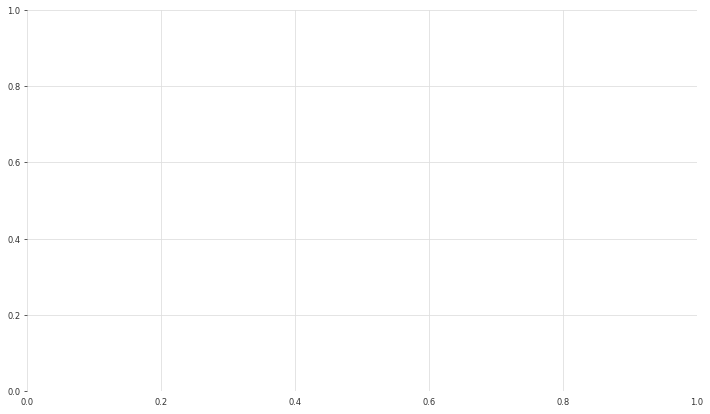

In [47]:
fig, ax = plt.subplots(1,1,figsize=(12,7))

In [50]:
train_year = train_df.set_index('date').groupby([pd.Grouper(freq='Y'), 'country'])[['num_sold']].sum()

In [51]:
sns.lineplot(x='date', y='num_sold', hue='country', data=train_year, ax=ax)

<AxesSubplot:xlabel='date', ylabel='num_sold'>

In [52]:
ax.set_title('Trend by year', fontsize=15, fontweight='bold', loc='left')
ax.grid(alpha=0.5)
plt.show()

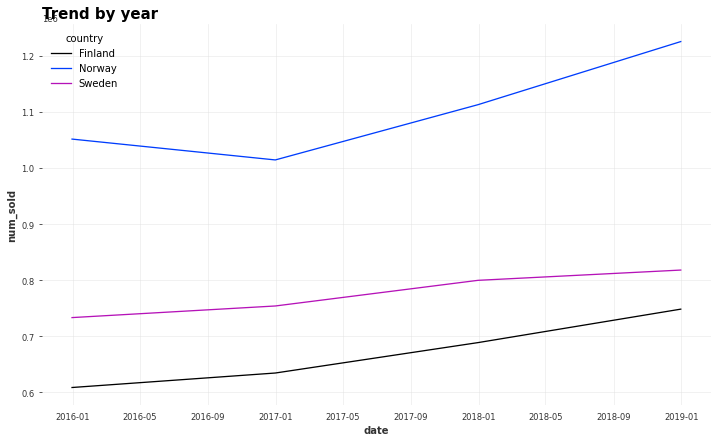

In [53]:
fig

## Trends by Country by Month

In [66]:
train_month_country = train_df.set_index('date').groupby([pd.Grouper(freq='M')])['num_sold'].mean()

In [61]:
train_country = train_df.set_index('date').groupby([pd.Grouper(freq='D'),'country'])['num_sold'].sum()

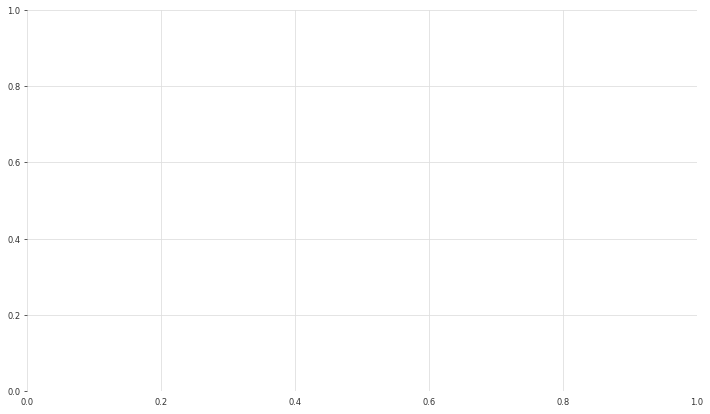

In [57]:
fig, ax = plt.subplots(1,1,figsize=(12,7));

In [65]:
train_country

date        country
2015-01-01  Finland    2761
            Norway     4543
            Sweden     3464
2015-01-02  Finland    2525
            Norway     4430
                       ... 
2018-12-30  Norway     8980
            Sweden     6227
2018-12-31  Finland    3951
            Norway     6275
            Sweden     4476
Name: num_sold, Length: 4383, dtype: int64

In [67]:
sns.lineplot(x='date', y='num_sold', data=train_country, ax=ax, label='daily', hue='country')
sns.lineplot(x='date', y='num_sold', data=train_month_country, ax=ax, label='monthly_mean', hue='country')
ax.set_title('Daily and monthly trends', fontsize=20, fontweight='bold', loc='left', y=1.03)
ax.grid(alpha=0.5)
ax.legend()
plt.show()

ValueError: Could not interpret value `num_sold` for parameter `y`